Training DQN agent...
DQN Episode 0/300, Score: 19.0, Avg Score: 19.0
DQN Episode 50/300, Score: 28.0, Avg Score: 29.0
DQN Episode 100/300, Score: 30.0, Avg Score: 37.1
DQN Episode 150/300, Score: 46.0, Avg Score: 54.5
DQN Episode 200/300, Score: 16.0, Avg Score: 75.8
DQN Episode 250/300, Score: 200.0, Avg Score: 101.0

Training PPO agent...
PPO Episode 0/300, Score: 10.0, Avg Score: 10.0
PPO Episode 50/300, Score: 200.0, Avg Score: 74.1
PPO Episode 100/300, Score: 197.0, Avg Score: 111.2
PPO Episode 150/300, Score: 198.0, Avg Score: 162.5
PPO Episode 200/300, Score: 200.0, Avg Score: 174.4
PPO Episode 250/300, Score: 200.0, Avg Score: 180.7


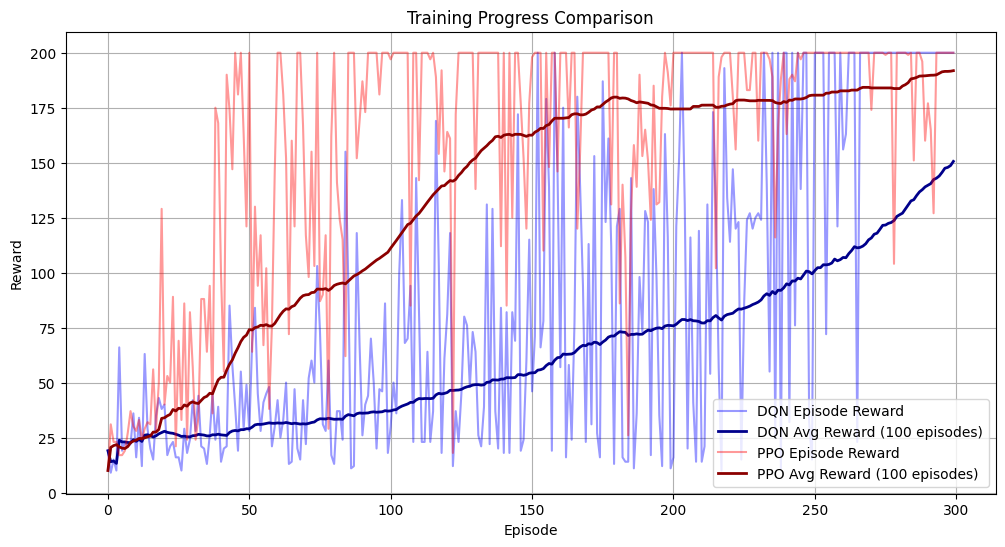


Testing DQN agent...
Episode 1: Balanced for 163 steps
Episode 2: Balanced for 180 steps
Episode 3: Balanced for 200 steps
Episode 4: Balanced for 200 steps
Episode 5: Balanced for 178 steps
Episode 6: Balanced for 200 steps
Episode 7: Balanced for 200 steps
Episode 8: Balanced for 200 steps
Episode 9: Balanced for 200 steps
Episode 10: Balanced for 178 steps
DQN Average Steps: 189.9

Testing PPO agent...
Episode 1: Balanced for 200 steps
Episode 2: Balanced for 200 steps
Episode 3: Balanced for 200 steps
Episode 4: Balanced for 200 steps
Episode 5: Balanced for 200 steps
Episode 6: Balanced for 200 steps
Episode 7: Balanced for 200 steps
Episode 8: Balanced for 200 steps
Episode 9: Balanced for 200 steps
Episode 10: Balanced for 200 steps
PPO Average Steps: 200.0

Final Comparison:
Metric                    DQN        PPO       
Average Training Reward   145.0      190.8     
Average Test Steps        189.9      200.0     


In [6]:
import torch
import torch.nn as nn
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque

# 修复张量转换问题
def to_tensor(data):
    """将数据转换为PyTorch张量，修复维度问题"""
    if isinstance(data, list):
        data = np.array(data)
    return torch.FloatTensor(data)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    
    def forward(self, x):
        return self.fc(x)
    
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=0.001)
        self.action_dim = action_dim
        self.gamma = 0.99
    
    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())
    
    def act(self, state, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_dim)
        state_tensor = to_tensor(state).unsqueeze(0)
        q_values = self.q_net(state_tensor)
        return q_values.argmax().item()
    
    def train(self, replay_buffer, batch_size=64):
        if len(replay_buffer) < batch_size:
            return
        
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
        
        states = to_tensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = to_tensor(next_states)
        dones = torch.FloatTensor(dones)
        
        q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_net(next_states).max(1)[0].detach()
        expected_q = rewards + self.gamma * next_q_values * (1 - dones)
        
        loss = nn.MSELoss()(q_values, expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

class PPONetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPONetwork, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.actor(x), self.critic(x)
    
class PPOAgent:
    def __init__(self, state_dim, action_dim):
        self.policy = PPONetwork(state_dim, action_dim)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=0.0003)
        self.action_dim = action_dim
        self.gamma = 0.99
        self.gae_lambda = 0.95
        self.eps_clip = 0.2
        self.K_epochs = 4
    
    def act(self, state):
        state_tensor = to_tensor(state).unsqueeze(0)
        with torch.no_grad():
            probs, _ = self.policy(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)
    
    def train(self, states, actions, log_probs, rewards, dones):
        states = to_tensor(states)
        actions = torch.LongTensor(actions)
        old_log_probs = torch.FloatTensor(log_probs)
        
        # 计算折扣回报
        returns = []
        discounted_return = 0
        for reward, done in zip(rewards[::-1], dones[::-1]):
            if done:
                discounted_return = 0
            discounted_return = reward + self.gamma * discounted_return
            returns.insert(0, discounted_return)
        
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        for _ in range(self.K_epochs):
            # 获取新策略概率
            new_probs, state_values = self.policy(states)
            dist = torch.distributions.Categorical(new_probs)
            new_log_probs = dist.log_prob(actions)
            
            # 计算熵和比率
            entropy = dist.entropy().mean()
            ratios = torch.exp(new_log_probs - old_log_probs.detach())
            
            # 计算优势函数
            advantages = returns - state_values.squeeze().detach()
            
            # 计算代理损失
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = nn.MSELoss()(state_values.squeeze(), returns)
            
            # 总损失
            loss = actor_loss + 0.5 * critic_loss - 0.01 * entropy
            
            # 更新策略
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

class ReplayBuffer:
    """经验回放缓冲区"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in idxs])
        return (
            np.array(states, dtype=np.float32), 
            np.array(actions), 
            np.array(rewards, dtype=np.float32), 
            np.array(next_states, dtype=np.float32), 
            np.array(dones, dtype=np.uint8)
        )
    
    def __len__(self):
        return len(self.buffer)

def train_dqn_agent(env, agent, episodes=500, max_steps=200, target_update=10):
    """训练DQN智能体"""
    replay_buffer = ReplayBuffer(10000)
    scores = []
    avg_scores = []
    score_window = deque(maxlen=100)
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        
        for step in range(max_steps):
            # 选择动作
            epsilon = max(0.01, 0.9 * (1 - episode / episodes))
            action = agent.act(state, epsilon)
            
            # 执行动作
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            
            # 存储经验
            replay_buffer.push(state, action, reward, next_state, done)
            
            # 训练
            agent.train(replay_buffer, batch_size=64)
            
            state = next_state
            if done:
                break
        
        # 记录分数
        scores.append(total_reward)
        score_window.append(total_reward)
        avg_scores.append(np.mean(score_window))
        
        # 定期更新目标网络
        if episode % target_update == 0:
            agent.update_target()
            
        # 打印进度
        if episode % 50 == 0:
            print(f"DQN Episode {episode}/{episodes}, Score: {total_reward}, Avg Score: {np.mean(score_window):.1f}")
    
    return scores, avg_scores

def train_ppo_agent(env, agent, episodes=500, max_steps=200):
    """训练PPO智能体"""
    scores = []
    avg_scores = []
    score_window = deque(maxlen=100)
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        states, actions, log_probs, rewards, dones = [], [], [], [], []
        
        for step in range(max_steps):
            # 选择动作
            action, log_prob = agent.act(state)
            
            # 执行动作
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            
            # 存储经验
            states.append(state)
            actions.append(action)
            log_probs.append(log_prob.item())
            rewards.append(reward)
            dones.append(done)
            
            state = next_state
            if done:
                break
        
        # 训练
        agent.train(states, actions, log_probs, rewards, dones)
        
        # 记录分数
        scores.append(total_reward)
        score_window.append(total_reward)
        avg_scores.append(np.mean(score_window))
        
        # 打印进度
        if episode % 50 == 0:
            print(f"PPO Episode {episode}/{episodes}, Score: {total_reward}, Avg Score: {np.mean(score_window):.1f}")
    
    return scores, avg_scores

# 修改后的测试函数
def test_agent(env, agent, episodes=10):
    total_steps = 0
    for ep in range(episodes):
        state, _ = env.reset()
        step_count = 0
        for step in range(200):
            # 根据智能体类型调用不同的动作选择方法
            if isinstance(agent, DQNAgent):
                # DQN使用epsilon-greedy策略
                action = agent.act(state, epsilon=0.01)
            elif isinstance(agent, PPOAgent):
                # PPO直接采样动作
                action, _ = agent.act(state)
            else:
                action = env.action_space.sample()
                
            next_state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            step_count = step + 1
            if done:
                break
            state = next_state
        
        total_steps += step_count
        print(f"Episode {ep+1}: Balanced for {step_count} steps")
    return total_steps / episodes

# 主程序
if __name__ == "__main__":
    env = gym.make('CartPole-v1')
    
    # DQN训练
    print("Training DQN agent...")
    dqn_agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)
    dqn_scores, dqn_avg = train_dqn_agent(env, dqn_agent, episodes=300)
    
    # PPO训练
    print("\nTraining PPO agent...")
    ppo_agent = PPOAgent(env.observation_space.shape[0], env.action_space.n)
    ppo_scores, ppo_avg = train_ppo_agent(env, ppo_agent, episodes=300)
    
    # 绘制训练曲线
    plt.figure(figsize=(12, 6))
    plt.plot(dqn_scores, alpha=0.4, label='DQN Episode Reward', color='blue')
    plt.plot(dqn_avg, linewidth=2, label='DQN Avg Reward (100 episodes)', color='darkblue')
    plt.plot(ppo_scores, alpha=0.4, label='PPO Episode Reward', color='red')
    plt.plot(ppo_avg, linewidth=2, label='PPO Avg Reward (100 episodes)', color='darkred')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Progress Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curve.png')
    plt.show()
    
    # 测试训练后的智能体
    print("\nTesting DQN agent...")
    dqn_avg_steps = test_agent(env, dqn_agent)
    print(f"DQN Average Steps: {dqn_avg_steps:.1f}")
    
    print("\nTesting PPO agent...")
    ppo_avg_steps = test_agent(env, ppo_agent)
    print(f"PPO Average Steps: {ppo_avg_steps:.1f}")
    
    # 打印最终对比结果
    print("\nFinal Comparison:")
    print(f"{'Metric':<25} {'DQN':<10} {'PPO':<10}")
    print(f"{'Average Training Reward':<25} {np.mean(dqn_avg[-10:]):<10.1f} {np.mean(ppo_avg[-10:]):<10.1f}")
    print(f"{'Average Test Steps':<25} {dqn_avg_steps:<10.1f} {ppo_avg_steps:<10.1f}")